In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
from collections import Counter
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, concatenate, Flatten
from keras.layers.core import Dense, Reshape, Lambda
from keras.utils import to_categorical
from keras import regularizers
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.initializers import Constant
from tensorflow import set_random_seed
import pickle
from sklearn.metrics import classification_report

BASE_DIR = "../.."
DATA_DIR = "data"
DATA_FILE = "balanced_data.csv"
WORD_EMBEDDING_DIM = 100
GLOVE_DIR = "glove.6B"
GLOVE_FILE = "glove.6B." +  str(WORD_EMBEDDING_DIM) + 'd.txt'
#GLOVE_WORDS = 400000
GLOVE_VOCSIZE = 400000
INS_USERNAME_EMBEDDING_DIM = 20
MAX_WORDS_IN_CAPTION = 40
SPLIT_RATIO = [0.7, 0.15, 0.15] # training : validation : test

data_path = os.path.join(BASE_DIR, DATA_DIR, DATA_FILE)
data = pd.read_csv(data_path)

Using TensorFlow backend.


In [2]:
N_ins_username = data.poster_instagram_username.nunique()
N_poster_account_type = data.poster_account_type.nunique()
N_media_type =data.media_type.nunique()
N_caption_type = data.caption_type.nunique()

raw_input_dim = MAX_WORDS_IN_CAPTION + 1 + \
                N_poster_account_type + N_media_type + N_caption_type

print(N_ins_username)
print(N_poster_account_type)
print(N_media_type)
print(N_caption_type)
print(raw_input_dim)

1337
5
6
6
58


# Transform the tabular data to usable numerial data to feed in the network
## Transform caption and username data -- for embedding

In [3]:
# build word : vec dictionary from GloVe
glove_path = os.path.join(BASE_DIR, GLOVE_DIR,  GLOVE_FILE)
glove_index = {}
with open(glove_path) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, dtype = 'float', sep=' ')
        glove_index[word] = coefs

# prepare tokenizer
captions = data.media_caption.astype(str)
token = Tokenizer()
token.fit_on_texts(captions)
vocab_size = len(token.word_index) + 1 # word_index is 1-indexed, puls 1-dim for OOV and padded words
print("The size of the vocabulary is: ", vocab_size)

# integer encode the documents
encoded_captions = token.texts_to_sequences(captions)
# pad documents to a max length of 4 words
padded_captions = pad_sequences(encoded_captions, maxlen=MAX_WORDS_IN_CAPTION, padding='post')

The size of the vocabulary is:  23376


In [4]:
# use "represented_data" matrix, to store the encoded data
represented_data = padded_captions.copy()

# create a weight matrix for all words in captions
embedding_matrix = np.zeros((vocab_size, WORD_EMBEDDING_DIM))
for word, idx in token.word_index.items(): # word_index is 1-indexed, zero vector for padding
    embedding_vector = glove_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector

In [5]:
# poster_instagram_username N_ins_username dim categorial, needs to be embedded to INS_USERNAME_EMBEDDING_DIM dim
def OrdinalEncoder(categories):
    """ An ordinal Encoder for data pre-processing,
        Not strictly ordinal, but does the work.
    
        Args:
            categories: numpy arrary or list of categories              
        Returns:
            numpy array of ordinal encoded entries        
    """
    counter = Counter(categories).most_common() # indices assigned based on number of occurances
    unique_ctgrs = [x[0] for x in counter] # list of categories, guaranteed in fixed order due to sorting
    encoder = {ctgr : idx for idx, ctgr in enumerate(unique_ctgrs)}
        
    res = [0] * len(categories)
    res = [encoder[ctgr] for ctgr in categories]
    return np.array(res, dtype='int')

In [6]:
ins_usernames = data.poster_instagram_username
encoded_ins_usernames = OrdinalEncoder(ins_usernames)
encoded_ins_usernames = np.array(encoded_ins_usernames).reshape(-1, 1)
# concatenate encoded_ins_usernames to represented_data
represented_data = np.concatenate((represented_data, encoded_ins_usernames), axis = 1)

In [7]:
print(len(represented_data))
print(len(represented_data[0]))

101914
41


## Transform poster_account_type, media_type and caption_type -- one-hot

In [8]:
for ctgr in ['poster_account_type', 'media_type', 'caption_type']:
    col=data[ctgr]
    one_hot_encoded = to_categorical(OrdinalEncoder(col))
    represented_data = np.concatenate((represented_data, one_hot_encoded), axis = 1)

In [9]:
print(len(represented_data))
print(len(represented_data[0]))
if len(represented_data[0]) != raw_input_dim:
    print("Input dimension is wrong!")

101914
58


# Split all data into training, validation and test sets
## Multi-hot encoding for multi-labels

In [10]:
def multi_hot_encoding(labels):
    """ multi-hot encoding for the labels of each meida post 
        Args:
            labels: list, dimension of rows may not be same
        Return:
            num_of_classes: int, total number of classes
            res: array, num_of_examples x num_of_classes, multi-hot encoded array
    """
    # number of classes
    num_examples, min_idx, max_idx = len(labels), float('inf'), -float('inf')
    for row in labels:
        for col in row:
            if col < min_idx:
                min_idx = col
            if col > max_idx:
                max_idx = col
    num_of_classes = max_idx - min_idx + 1
    
    res = np.zeros((num_examples, max_idx-min_idx+1), dtype = int)
    for row in range(len(labels)):
        lbls = labels[row]
        for col in lbls:
            res[row, col] = 1
    return num_of_classes, res
    

In [11]:
labels_str = data.label.values
labels = []
for str_label in labels_str:
    label = [int(i) for i in str_label[1:-1].split(',')]
    labels.append(label)

num_of_classes, encoded_labels_arr = multi_hot_encoding(labels)
represented_data = np.concatenate((represented_data, encoded_labels_arr), axis = 1)

In [12]:
def split_data(orig_data, split_ratio, num_of_classes):
    """ Split dataframe into train, validation and test datasets."""
    np.random.seed(42)
    np.random.shuffle(orig_data)
    data_after_split, tmp, length = {}, {}, len(orig_data)
    
    tmp['train'], tmp['val'], tmp['test'] = np.split(
        orig_data, [int(split_ratio[0] * length), int(1 - split_ratio[2] * length)], axis=0)
    
    for sett in ['train', 'val', 'test']:
        X = tmp[sett][:, :-num_of_classes]
        Y = tmp[sett][:, -num_of_classes:]
        data_after_split['X' + '_' + sett] = X
        data_after_split['Y' + '_' + sett] = Y

    print(data_after_split['X_train'].shape, data_after_split['Y_train'].shape,
          data_after_split['X_val'].shape, data_after_split['Y_val'].shape,
          data_after_split['X_test'].shape, data_after_split['Y_test'].shape)
    return data_after_split

In [13]:
print(represented_data.shape)
data_after_split = split_data(represented_data, SPLIT_RATIO, num_of_classes)

(101914, 98)
(71339, 58) (71339, 40) (15289, 58) (15289, 40) (15286, 58) (15286, 40)


# Now the tabular data are ready to be fed into embedding layers and feed-forward network

In [14]:
# To ensure reproducible results
# https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
np.random.seed(42)
random.seed(42)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.set_random_seed(42)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Integer IDs representing 1-hot encodings
media_caption_in = Input(shape=(MAX_WORDS_IN_CAPTION,))
poster_instagram_username_in = Input(shape=(1,))
others_in = Input(shape=(N_poster_account_type + N_media_type + N_caption_type, ))

# Two Embedding layers
caption_embedding = Embedding(input_dim=vocab_size, output_dim=WORD_EMBEDDING_DIM, 
                              embeddings_initializer=Constant(embedding_matrix), 
                              input_length=MAX_WORDS_IN_CAPTION, trainable=True, 
                              name = 'word_emb')(media_caption_in)

ins_username_embedding = Embedding(N_ins_username, INS_USERNAME_EMBEDDING_DIM, 
                                   name = 'insID_emb')(poster_instagram_username_in)

# Reshape and merge all embeddings together
avg_caption_embedding = Lambda(lambda x: K.mean(x, axis = 1, keepdims=False))(caption_embedding)

reshape_caption_embedding = Reshape(target_shape=(WORD_EMBEDDING_DIM,))
reshape_ins_username = Reshape(target_shape=(INS_USERNAME_EMBEDDING_DIM,))

combined = concatenate([reshape_caption_embedding(avg_caption_embedding), 
                  reshape_ins_username(ins_username_embedding), others_in])
    


# Hidden layers
regularizer_param = 0.0003
hidden_1 = Dense(64, activation='relu', 
                 kernel_regularizer=regularizers.l2(regularizer_param))(combined)
hidden_2 = Dense(32, activation='relu', 
                 kernel_regularizer=regularizers.l2(regularizer_param))(hidden_1)
output = Dense(num_of_classes, activation='sigmoid', 
               kernel_regularizer=regularizers.l2(regularizer_param))(hidden_2)

# Compile with categorical crossentropy and adam
model = Model(inputs=[media_caption_in, poster_instagram_username_in, others_in], outputs = [output])

##----- Important: In multi-label classification problems. It is -----##
##----- easy to obtain high accuracy because of sparsity of labels -----##
##----- Use customized metrics: precision, recall, and Exact Match Ratio(Subset accuracy) -----##
## https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff
#https://stats.stackexchange.com/questions/12702/what-are-the-measure-for-accuracy-of-multilabel-data/168952

#There is a difference between the metric on training dataset and on validation dataset. 
#For the val set the metric is calculated at epoch end for your whole val dataset. 
#For the train set: The metric is calculated on batch end and the average keeps getting updated till epochs end.
#As you can see the metric for the train set is evaluated on the fly with each batch was evaluated using different weights. 
#That's why the train metric shows sometimes strange behaviour.

def precision(y_true, y_pred):
    #Precision metric.
    y_pred = K.cast(K.greater(y_pred,0.5),dtype=float)
    true_positives = K.sum(K.round(y_true * y_pred))
    predicted_positives = K.sum(K.round(y_pred))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    #Recall metric.
    y_pred = K.cast(K.greater(y_pred,0.5),dtype=float)
    true_positives = K.sum(K.round(y_true * y_pred))
    actural_positives = K.sum(K.round(y_true))
    recall = true_positives / (actural_positives + K.epsilon())
    return recall

#def Hamming_loss(y_true, y_pred):
#    # y_pred is not filterd by 0.5 yet
#    tmp = K.abs(y_true-y_pred)
#    return K.mean(K.cast(K.greater(tmp,0.5),dtype=float))

def exact_match_ratio(y_true, y_pred):
    #pred = tf.equal(tf.round(y_logits), tf.round(y_true))
    predictions = tf.to_float(tf.greater_equal(y_pred, 0.5))
    pred_match = tf.equal(predictions, tf.round(y_true))
    exact_match = tf.reduce_min(tf.to_float(pred_match), axis=1)
    return tf.reduce_mean(exact_match)    
    
model.compile(loss='binary_crossentropy', 
            optimizer='adam', metrics=[precision, recall, exact_match_ratio])

print(model.summary())

val_data = ([data_after_split['X_val'][:, :MAX_WORDS_IN_CAPTION], 
             data_after_split['X_val'][:,MAX_WORDS_IN_CAPTION], 
             data_after_split['X_val'][:,MAX_WORDS_IN_CAPTION+1:]],
             data_after_split['Y_val'])
batchSize = 128

history = model.fit([data_after_split['X_train'][:, :MAX_WORDS_IN_CAPTION], 
                     data_after_split['X_train'][:,MAX_WORDS_IN_CAPTION], 
                     data_after_split['X_train'][:,MAX_WORDS_IN_CAPTION+1:]],
                     data_after_split['Y_train'],
                     validation_data = val_data, batch_size=batchSize, epochs=50)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
word_emb (Embedding)            (None, 40, 100)      2337600     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 100)          0           word_emb[0][0]         

71339/71339 [==============================] - 15s 203us/step - loss: 0.1074 - precision: 0.8283 - recall: 0.2244 - exact_match_ratio: 0.2112 - val_loss: 0.1079 - val_precision: 0.8420 - val_recall: 0.2214 - val_exact_match_ratio: 0.2189
Epoch 19/50
71339/71339 [==============================] - 14s 192us/step - loss: 0.1067 - precision: 0.8281 - recall: 0.2293 - exact_match_ratio: 0.2159 - val_loss: 0.1069 - val_precision: 0.8142 - val_recall: 0.2420 - val_exact_match_ratio: 0.2268
Epoch 20/50
71339/71339 [==============================] - 14s 196us/step - loss: 0.1061 - precision: 0.8287 - recall: 0.2344 - exact_match_ratio: 0.2199 - val_loss: 0.1065 - val_precision: 0.8276 - val_recall: 0.2310 - val_exact_match_ratio: 0.2221
Epoch 21/50
71339/71339 [==============================] - 14s 202us/step - loss: 0.1055 - precision: 0.8286 - recall: 0.2379 - exact_match_ratio: 0.2229 - val_loss: 0.1059 - val_precision: 0.8206 - val_recall: 0.2481 - val_exact_match_ratio: 0.2316
Epoch 22/50


In [15]:
# save model and history
with open('DNN_history', 'wb') as fin:
        pickle.dump(history.history, fin)
model.save('DNN_model.h5')

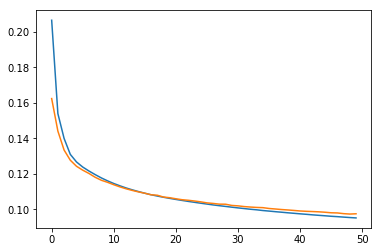

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [17]:
def get_precision(y_true, y_pred):
    #Precision metric.
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred <0.5] = 0
    true_positives = np.sum(y_pred*y_true)
    predicted_positives = np.sum(y_pred)
    return true_positives / predicted_positives

def get_recall(y_true, y_pred):
    #Recall metric.
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred <0.5] = 0
    true_positives = np.sum(y_pred*y_true)
    actural_positives = np.sum(y_true)
    return true_positives / actural_positives

def get_exact_match_ratio(y_true, y_pred):
    match = np.equal(y_pred, y_true)
    match = np.amin(match, axis=1)
    exact_match_ratio = np.mean(match)
    return exact_match_ratio

In [18]:
y_pred = model.predict([data_after_split['X_test'][:, :MAX_WORDS_IN_CAPTION], 
               data_after_split['X_test'][:,MAX_WORDS_IN_CAPTION], 
               data_after_split['X_test'][:,MAX_WORDS_IN_CAPTION+1:]])
y_true = data_after_split['Y_test']

precision, recall,  = get_precision(y_true, y_pred), get_recall(y_true, y_pred)
exact_match_ratio = get_exact_match_ratio(y_true, y_pred)

print("precision, recall and exact match ratio for test set are %.4f, %.4f and %.4f" \
      %(precision, recall, exact_match_ratio))

precision, recall and exact match ratio for test set are 0.7975, 0.3263 and 0.3057


In [19]:
classID_className = {0: 'color cosmetics:eye:eyebrow', 1: 'skincare:skincare:moisturizer', 2: 'color cosmetics:eye:eyeshadow', 3: 'color cosmetics:eye:mascara', 4: 'accessories:accessories:brush', 5: 'fragrance:fragrance:fragrance', 6: 'skincare:skincare:cleanser', 7: 'accessories:accessories:tool', 8: 'nail:nail:nail polish', 9: 'color cosmetics:eye:eye palette', 10: 'bath body:bath body:wash', 11: 'hair:style:styling products', 12: 'skincare:skincare:treatments', 13: 'color cosmetics:face:powder', 14: 'skincare:skincare:mask', 15: 'bath body:bath body:body lotion', 16: 'hair:cleanse:conditioner', 17: 'color cosmetics:cheek:cheek palette', 18: 'color cosmetics:lip:lipstick', 19: 'hair:treat:hair treatments', 20: 'color cosmetics:cheek:highlighter', 21: 'hair:cleanse:shampoo', 22: 'color cosmetics:face:setting spray', 23: 'color cosmetics:cheek:blush', 24: 'skincare:skincare:face suncare', 25: 'color cosmetics:eye:eyeliner', 26: 'color cosmetics:face:face palette', 27: 'color cosmetics:face:foundation', 28: 'color cosmetics:lip:lip balm', 29: 'skincare:skincare:face mist', 30: 'skincare:skincare:eyecare', 31: 'color cosmetics:eye:lash', 32: 'color cosmetics:lip:lip gloss', 33: 'color cosmetics:face:face primer', 34: 'color cosmetics:face:concealer', 35: 'color cosmetics:cheek:bronzer', 36: 'skincare:skincare:toner', 37: 'color cosmetics:lip:lip liner', 38: 'bath body:bath body:body suncare', 39: 'bath body:bath body:body glitter'}
target_names = [i.split(':')[2] for i in classID_className.values()]
print(classification_report(y_true, y_pred, target_names = target_names))

                  precision    recall  f1-score   support

         eyebrow       0.58      0.19      0.29       326
     moisturizer       0.40      0.00      0.01       405
       eyeshadow       0.00      0.00      0.00       311
         mascara       0.45      0.15      0.22       613
           brush       0.88      0.44      0.59       498
       fragrance       0.90      0.53      0.66       480
        cleanser       0.78      0.10      0.18       662
            tool       0.87      0.66      0.75       953
     nail polish       0.98      0.78      0.87       506
     eye palette       0.70      0.30      0.42       880
            wash       0.73      0.68      0.70       534
styling products       0.75      0.70      0.72       771
      treatments       0.73      0.05      0.09       844
          powder       0.00      0.00      0.00       438
            mask       0.00      0.00      0.00       292
     body lotion       0.70      0.34      0.46       565
     conditio

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
